In [151]:
# Imports
import pandas as pd

In [152]:
# Load in data

# Encoding is specified for each import to resolve an "unexpected continuation byte" error

# https://www.kaggle.com/code/nelgiriyewithana/introduction-to-world-educational-data/notebook
world_education_data = pd.read_csv("Data/Global_Education.csv", encoding="iso-8859-1")

# https://databank.worldbank.org/source/education-statistics-%5E-all-indicators
world_bank_education_data = pd.read_csv("Data/World Bank Education Data.csv", encoding="ascii")

# The following are from the UNESCO Institute for Statistics Data Browser for Education available here: https://databrowser.uis.unesco.org/browser/EDUCATION/UIS-SDG4Monitoring
teacher_data = pd.read_csv("Data/UIS Teacher Data/data.csv")
education_years_data = pd.read_csv("Data/UIS Years of Education/data.csv")
teacher_attrition_data = pd.read_csv("Data/UIS Teacher Attrition/data.csv")

In [153]:
#UIS Data

#Dropping values we do not need
teacher_data = teacher_data.drop(["qualifier", "magnitude"], axis=1)
education_years_data = education_years_data.drop(["qualifier", "magnitude"], axis=1)
teacher_attrition_data = teacher_attrition_data.drop(["qualifier", "magnitude"], axis=1)

In [154]:
# Work out which year has the most complete data
print((teacher_data["year"].value_counts() + education_years_data["year"].value_counts() + teacher_attrition_data["year"].value_counts()).sort_values())

year
2024     150.0
2011     663.0
2012     691.0
2013     906.0
2014    1035.0
2015    1090.0
2017    1119.0
2016    1120.0
2018    1143.0
2020    1147.0
2023    1161.0
2019    1165.0
2022    1166.0
2021    1199.0
2010       NaN
Name: count, dtype: float64


In [155]:
#2021 is the most complete year, so we will use it
years = range(2010, 2022)

new_data = pd.DataFrame(columns=["indicator", "country"])

for i in years: 
    new_data[str(i)] = []

In [156]:
#Data in the files is sorted by indicatorId which makes it easier to add them to our new_data dataframe

def load_into_data(data: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    for index, _ in dataset.iterrows():
        if index == 0:
            lastId = None
            lastGeo = None
        else:
            lastId = dataset.iloc[index -1]["indicatorId"]
            lastGeo = dataset.iloc[index -1]["geoUnit"]

        currId = dataset.iloc[index]["indicatorId"]
        currGeo = dataset.iloc[index]["geoUnit"]
        year = dataset.iloc[index]["year"]
        
        if year > 2021:
            continue

        if lastId != currId or lastGeo != currGeo:
            df = pd.DataFrame({"indicator": [currId], "country": [currGeo]})
            data = pd.concat([data, df], ignore_index=True)
        data.at[len(data) -1, str(year)] = dataset.iloc[index]["value"]
    return data

new_data = load_into_data(new_data,teacher_data)
new_data = load_into_data(new_data,education_years_data)
new_data = load_into_data(new_data,teacher_attrition_data)



In [157]:
data = new_data.copy(deep=True)

In [158]:
def get_average_for_row(row: pd.Series) -> float:
    total = 0
    count = 0
    for cell in row:
        try:
            cell = float(cell)
        except ValueError:
            continue
        if math.isnan(cell):
            continue
        total += cell
        count += 1

    if count == 0:
        return 0
    
    return total / count

In [159]:
# Replacing missing values

import math
# Fill in missing 2021 values with the average of previous years

# Get which indicies are missing a value of 2021.
indexes_to_fill = []
for index, row in data.iterrows():
    if math.isnan(row["2021"]):
        indexes_to_fill.append(index)

print(indexes_to_fill)

for i in indexes_to_fill:
    data.at[i, "2021"] = get_average_for_row(data.iloc[i])

data
    

[6, 9, 13, 17, 18, 19, 22, 26, 27, 28, 29, 32, 36, 40, 42, 45, 48, 53, 54, 55, 56, 58, 59, 61, 63, 64, 68, 69, 71, 72, 74, 76, 78, 82, 84, 86, 87, 88, 89, 94, 96, 97, 98, 101, 103, 107, 110, 112, 115, 118, 121, 125, 127, 133, 135, 139, 143, 148, 149, 150, 153, 159, 166, 169, 171, 174, 179, 180, 186, 190, 194, 195, 197, 201, 206, 207, 210, 212, 213, 215, 219, 222, 224, 227, 228, 229, 230, 236, 239, 241, 244, 246, 247, 248, 251, 254, 257, 260, 263, 264, 268, 272, 273, 275, 281, 283, 287, 291, 296, 299, 300, 303, 305, 314, 316, 317, 322, 328, 332, 334, 335, 337, 338, 343, 344, 345, 346, 347, 348, 349, 350, 351, 353, 354, 355, 357, 359, 361, 362, 363, 371, 372, 375, 376, 377, 378, 379, 380, 381, 383, 388, 389, 393, 396, 399, 400, 406, 408, 411, 415, 419, 420, 421, 422, 425, 429, 430, 431, 432, 435, 439, 441, 444, 446, 449, 453, 458, 459, 460, 461, 463, 464, 466, 468, 469, 473, 474, 476, 477, 479, 481, 483, 487, 489, 491, 492, 493, 494, 499, 501, 502, 503, 508, 512, 515, 517, 520, 523, 526,

,indicator,country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,PTRHC.02.QUALIFIED,AGO,NaN,NaN,NaN,NaN,NaN,NaN,88.033783,NaN,NaN,NaN,NaN,67.013420
1,PTRHC.02.QUALIFIED,ALB,NaN,NaN,NaN,28.42535,25.840099,24.001751,22.056330,20.786989,23.51306,24.01643,20.371010,20.236031
2,PTRHC.02.QUALIFIED,AND,NaN,NaN,NaN,14.08721,13.703910,13.408840,13.684210,13.883440,13.27711,12.56213,12.051720,11.747060
3,PTRHC.02.QUALIFIED,ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.26619,26.76902,23.275150,21.276951
4,PTRHC.02.QUALIFIED,ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.27090,6.20682,6.918270,4.534200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,TATTRR.2T3,TCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.879030
1597,TATTRR.2T3,TKL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1598,TATTRR.2T3,TUV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.619049,1.515150
1599,TATTRR.2T3,UZB,NaN,NaN,NaN,NaN,NaN,NaN,3.150820,NaN,NaN,NaN,NaN,3.150820


In [160]:
# Converting country codes to names
import pycountry

for index, _ in data.iterrows():
    data.at[index, "country"] = pycountry.countries.get(alpha_3 = data.at[index, "country"]).name

data

,indicator,country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,PTRHC.02.QUALIFIED,Angola,NaN,NaN,NaN,NaN,NaN,NaN,88.033783,NaN,NaN,NaN,NaN,67.013420
1,PTRHC.02.QUALIFIED,Albania,NaN,NaN,NaN,28.42535,25.840099,24.001751,22.056330,20.786989,23.51306,24.01643,20.371010,20.236031
2,PTRHC.02.QUALIFIED,Andorra,NaN,NaN,NaN,14.08721,13.703910,13.408840,13.684210,13.883440,13.27711,12.56213,12.051720,11.747060
3,PTRHC.02.QUALIFIED,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.26619,26.76902,23.275150,21.276951
4,PTRHC.02.QUALIFIED,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.27090,6.20682,6.918270,4.534200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,TATTRR.2T3,Turks and Caicos Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.879030
1597,TATTRR.2T3,Tokelau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1598,TATTRR.2T3,Tuvalu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.619049,1.515150
1599,TATTRR.2T3,Uzbekistan,NaN,NaN,NaN,NaN,NaN,NaN,3.150820,NaN,NaN,NaN,NaN,3.150820


In [161]:
# Removing all but 2021

data = data.drop(["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"], axis=1)
data

,indicator,country,2021
0,PTRHC.02.QUALIFIED,Angola,67.013420
1,PTRHC.02.QUALIFIED,Albania,20.236031
2,PTRHC.02.QUALIFIED,Andorra,11.747060
3,PTRHC.02.QUALIFIED,United Arab Emirates,21.276951
4,PTRHC.02.QUALIFIED,Armenia,4.534200
...,...,...,...
1596,TATTRR.2T3,Turks and Caicos Islands,9.879030
1597,TATTRR.2T3,Tokelau,0.000000
1598,TATTRR.2T3,Tuvalu,1.515150
1599,TATTRR.2T3,Uzbekistan,3.150820


In [162]:
columns = ["country"]
columns.extend(data["indicator"].unique())

final_data = pd.DataFrame(columns=columns)

final_data

,country,PTRHC.02.QUALIFIED,PTRHC.1.QUALIFIED,PTRHC.2T3.QUALIFIED,QUTP.02,QUTP.1,QUTP.2T3,YEARS.FC.COMP.1T3,YEARS.FC.FREE.02,YEARS.FC.FREE.1T3,TATTRR.02,TATTRR.1,TATTRR.2T3


In [163]:
for index, _ in data.iterrows():
    country = data.at[index, "country"]
    indicator = data.at[index, "indicator"]
    value = data.at[index, "2021"]
    
    country_index = final_data["country"][final_data["country"] == country].index.to_list()

    if len(country_index) == 0:
        final_data = pd.concat([final_data, pd.Series()], ignore_index=True)
        final_data.at[len(final_data), "country"] = country
        country_index = len(final_data) -1
    else:
        country_index = country_index[0]

    final_data.at[country_index, indicator] = value
    

In [164]:
print(final_data.isnull().sum())
final_data = final_data.drop([0], axis=1)
final_data

country                  0
PTRHC.02.QUALIFIED      87
PTRHC.1.QUALIFIED       66
PTRHC.2T3.QUALIFIED     88
QUTP.02                 83
QUTP.1                  64
QUTP.2T3                81
YEARS.FC.COMP.1T3        0
YEARS.FC.FREE.02        22
YEARS.FC.FREE.1T3       20
TATTRR.02              156
TATTRR.1               138
TATTRR.2T3             162
0                      214
dtype: int64


,country,PTRHC.02.QUALIFIED,PTRHC.1.QUALIFIED,PTRHC.2T3.QUALIFIED,QUTP.02,QUTP.1,QUTP.2T3,YEARS.FC.COMP.1T3,YEARS.FC.FREE.02,YEARS.FC.FREE.1T3,TATTRR.02,TATTRR.1,TATTRR.2T3
0,Angola,67.01342,66.568092,33.637951,65.18721,80.972061,83.136627,9.0,1.0,9.0,NaN,14.70824,NaN
1,Albania,20.236031,20.24106,17.838289,67.658348,80.427193,56.795052,9.0,3.0,12.0,0.68054,4.99586,8.30288
2,Andorra,11.74706,10.02439,8.04523,100.0,100.0,100.0,11.0,0.0,10.0,5.74713,3.16302,4.63918
3,United Arab Emirates,21.276951,16.41136,9.66622,100.0,100.0,100.0,12.0,2.0,12.0,NaN,NaN,NaN
4,Armenia,4.5342,19.23551,11.14434,100.0,100.0,100.0,12.0,3.0,12.0,9.16542,4.16563,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Somalia,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
210,Slovenia,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,13.0,NaN,NaN,NaN
211,Sweden,NaN,NaN,NaN,NaN,NaN,NaN,9.0,1.0,12.0,NaN,NaN,NaN
212,Türkiye,NaN,NaN,NaN,NaN,NaN,NaN,12.0,3.0,12.0,NaN,NaN,NaN


In [165]:
# World Bank Education data
world_bank_education_data = world_bank_education_data.drop(world_bank_education_data.columns[[1, 3]], axis=1)

for index, row in world_bank_education_data.iterrows():
    if world_bank_education_data.loc[index]["2021 [YR2021]"] == "..":
        world_bank_education_data.loc[index]["2021 [YR2021]"] = get_average_for_row(world_bank_education_data.loc[index])

world_bank_education_data

/tmp/ipykernel_40993/1122652897.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  world_bank_education_data.loc[index]["2021 [YR2021]"] = get_average_for_row(world_bank_education_data.loc[index])


,Country Name,Series,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Afghanistan,Human Capital Index (HCI): Expected Years of S...,..,..,..,..,..,..,..,..,...,..,..,9.21,..,..,..,9.21,..,..,..
1,Afghanistan,Human Capital Index (HCI): Expected Years of S...,..,..,..,..,..,..,..,..,...,..,..,6.73,..,..,..,6.73,..,..,..
2,Afghanistan,Human Capital Index (HCI): Expected Years of S...,..,..,..,..,..,..,..,..,...,..,..,8.58,..,..,..,8.58,..,..,..
3,Afghanistan,Government expenditure on secondary education ...,..,..,..,..,..,..,..,..,...,0.79299,0.92321,0.90325,..,..,..,0.870019,..,..,..
4,Afghanistan,Government expenditure on tertiary education a...,..,..,..,..,..,..,..,..,...,0.51942,..,..,..,..,..,0.390228,..,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,Zimbabwe,Human Capital Index (HCI): Expected Years of S...,..,..,..,..,..,..,..,..,...,..,..,9.99,..,..,..,9.99,..,..,..
1628,Zimbabwe,Human Capital Index (HCI): Expected Years of S...,..,..,..,..,..,..,..,..,...,..,..,10.01,..,..,..,10.01,..,..,..
1629,Zimbabwe,Government expenditure on secondary education ...,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,1.305727,..,..,..
1630,Zimbabwe,Government expenditure on tertiary education a...,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,0.788906,..,..,..


In [166]:
world_bank_education_data.drop(world_bank_education_data.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,-1, -2, -3]], axis = 1)

,Country Name,Series,2021 [YR2021]
0,Afghanistan,Human Capital Index (HCI): Expected Years of S...,9.21
1,Afghanistan,Human Capital Index (HCI): Expected Years of S...,6.73
2,Afghanistan,Human Capital Index (HCI): Expected Years of S...,8.58
3,Afghanistan,Government expenditure on secondary education ...,0.870019
4,Afghanistan,Government expenditure on tertiary education a...,0.390228
...,...,...,...
1627,Zimbabwe,Human Capital Index (HCI): Expected Years of S...,9.99
1628,Zimbabwe,Human Capital Index (HCI): Expected Years of S...,10.01
1629,Zimbabwe,Government expenditure on secondary education ...,1.305727
1630,Zimbabwe,Government expenditure on tertiary education a...,0.788906


In [167]:
world_bank_education_data.rename({"Country Name": "country"})
columns = ["country"]
columns.extend(world_bank_education_data["Series"].unique())
final_world_bank_education_data = pd.DataFrame(columns=columns)

for index, _ in world_bank_education_data.iterrows():
    country = world_bank_education_data.at[index, "Country Name"]
    indicator = world_bank_education_data.at[index, "Series"]
    indexes: list = final_world_bank_education_data[final_world_bank_education_data["country"] == country].index.to_list()

    if len(indexes) == 0:
        final_world_bank_education_data.loc[len(final_world_bank_education_data)] = pd.Series()
        final_world_bank_education_data.at[final_world_bank_education_data.index[-1], "country"] = country
        indexes.append(len(final_world_bank_education_data) -1)
    final_world_bank_education_data.at[indexes[0], indicator] = world_bank_education_data.iloc[index]["2021 [YR2021]"]

In [168]:
world_education_data = world_education_data.drop(world_education_data.columns[[1,2,-1,-4]], axis=1)

In [169]:
world_education_data.rename(columns={"Countries and areas": "country"}, inplace=True)

In [170]:
# Joining data together
data = pd.merge(final_world_bank_education_data, world_education_data, on="country")
data = pd.merge(data, final_data, on="country")

In [171]:
data

,country,"Human Capital Index (HCI): Expected Years of School, Male","Human Capital Index (HCI): Expected Years of School, Female","Human Capital Index (HCI): Expected Years of School, Total",Government expenditure on secondary education as % of GDP (%),Government expenditure on tertiary education as % of GDP (%),Government expenditure on primary education as % of GDP (%),OOSR_Pre0Primary_Age_Male,OOSR_Pre0Primary_Age_Female,OOSR_Primary_Age_Male,...,PTRHC.2T3.QUALIFIED,QUTP.02,QUTP.1,QUTP.2T3,YEARS.FC.COMP.1T3,YEARS.FC.FREE.02,YEARS.FC.FREE.1T3,TATTRR.02,TATTRR.1,TATTRR.2T3
0,Afghanistan,9.21,6.73,8.58,0.870019,0.390228,1.94682,0,0,0,...,44.833747,NaN,78.443321,72.971651,9.0,1.0,12.0,NaN,NaN,NaN
1,Albania,13.08,12.89,12.99,0.806952,0.735245,2.01613,4,2,6,...,17.838289,67.658348,80.427193,56.795052,9.0,3.0,12.0,0.68054,4.99586,8.30288
2,Algeria,11.01,11.84,11.42,1.821173,1.16981,1.601133,0,0,0,...,NaN,NaN,100.0,NaN,10.0,1.0,12.0,0.01058,3.8994,NaN
3,Andorra,0,0,0,0.6337,0.134172,0.661137,0,0,0,...,8.04523,100.0,100.0,100.0,11.0,0.0,10.0,5.74713,3.16302,4.63918
4,Angola,8.69,7.07,7.89,1.06928,0.187065,0.745475,31,39,0,...,33.637951,65.18721,80.972061,83.136627,9.0,1.0,9.0,NaN,14.70824,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Uruguay,0,0,11.78,1.141612,0.796504,0.95779,2,1,3,...,NaN,NaN,100.0,NaN,12.0,2.0,12.0,NaN,NaN,NaN
163,Uzbekistan,0,0,0,0,0,0,53,55,0,...,9.79781,100.0,100.0,100.0,12.0,4.0,12.0,0.8952,2.03907,3.15082
164,Vanuatu,10.53,10.77,10.64,2.375857,0.59755,2.458621,38,38,8,...,24.753759,100.0,100.0,100.0,0.0,NaN,NaN,NaN,NaN,NaN
165,Zambia,0,0,9.15,0.633537,0.43014,1.921707,0,0,17,...,NaN,NaN,95.851966,NaN,7.0,0.0,7.0,NaN,NaN,NaN


In [172]:
data = data.astype({col: float for col in data.columns[1:]})

In [173]:
data.isnull().sum()

country                                                            0
Human Capital Index (HCI): Expected Years of School, Male          0
Human Capital Index (HCI): Expected Years of School, Female        0
Human Capital Index (HCI): Expected Years of School, Total         0
Government expenditure on secondary education as % of GDP (%)      0
Government expenditure on tertiary education as % of GDP (%)       0
Government expenditure on primary education as % of GDP (%)        0
OOSR_Pre0Primary_Age_Male                                          0
OOSR_Pre0Primary_Age_Female                                        0
OOSR_Primary_Age_Male                                              0
OOSR_Primary_Age_Female                                            0
OOSR_Lower_Secondary_Age_Male                                      0
OOSR_Lower_Secondary_Age_Female                                    0
OOSR_Upper_Secondary_Age_Male                                      0
OOSR_Upper_Secondary_Age_Female   

In [174]:
# Filling in missing variables

# For years of free and compulsory schooling, I am assuming null means 0
data["YEARS.FC.COMP.1T3"] = data["YEARS.FC.COMP.1T3"].fillna(0)
data["YEARS.FC.FREE.02"] = data["YEARS.FC.FREE.02"].fillna(0)
data["YEARS.FC.FREE.1T3"] = data["YEARS.FC.FREE.1T3"].fillna(0)

# For teacher attrition, I am going to drop the values as over 2/3 of countries have no data
data = data.drop(["TATTRR.02", "TATTRR.1", "TATTRR.2T3"], axis=1)

In [175]:
# For teacher:pupil ratios, I have chosen to replace them with the average worldwide value
data["PTRHC.02.QUALIFIED"] = data["PTRHC.02.QUALIFIED"].fillna(get_average_for_row(data["PTRHC.02.QUALIFIED"]))
data["PTRHC.1.QUALIFIED"] = data["PTRHC.1.QUALIFIED"].fillna(get_average_for_row(data["PTRHC.1.QUALIFIED"]))
data["PTRHC.2T3.QUALIFIED"] = data["PTRHC.2T3.QUALIFIED"].fillna(get_average_for_row(data["PTRHC.2T3.QUALIFIED"]))

# For percentage of qualified teachers, I have chosen to replace them with the average worldwide value
data["QUTP.02"] = data["QUTP.02"].fillna(get_average_for_row(data["QUTP.02"]))
data["QUTP.1"] = data["QUTP.1"].fillna(get_average_for_row(data["QUTP.1"]))
data["QUTP.2T3"] = data["QUTP.2T3"].fillna(get_average_for_row(data["QUTP.2T3"]))

In [176]:
data.isnull().sum().sort_values()

country                                                          0
Human Capital Index (HCI): Expected Years of School, Male        0
Human Capital Index (HCI): Expected Years of School, Female      0
Human Capital Index (HCI): Expected Years of School, Total       0
Government expenditure on secondary education as % of GDP (%)    0
Government expenditure on tertiary education as % of GDP (%)     0
Government expenditure on primary education as % of GDP (%)      0
OOSR_Pre0Primary_Age_Male                                        0
OOSR_Pre0Primary_Age_Female                                      0
OOSR_Primary_Age_Male                                            0
OOSR_Primary_Age_Female                                          0
OOSR_Lower_Secondary_Age_Male                                    0
OOSR_Lower_Secondary_Age_Female                                  0
OOSR_Upper_Secondary_Age_Male                                    0
OOSR_Upper_Secondary_Age_Female                               

In [177]:
# Multivariate Analysis
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def multivariate_analysis(x: pd.Series, y: pd.Series) -> float:
    return pearsonr(x, y)

In [178]:
def calculate_corrs():
    correlations = []
    strong_corr = []
    medium_corr = []
    index = 2
    for series_name, series in data.items():
        if series_name == "country":
            continue
        for col in data.columns[index:]:
            corr = multivariate_analysis(series, data[col])
            correlations.append({"x": series_name, "y": data[col].name, "value": corr.statistic, "pvalue": corr.pvalue})
        index += 1
    correlations = pd.DataFrame.from_dict(correlations)
    # Get all results that indicate high correlations
    strong_corr = correlations.query("pvalue <= 0.05 & value >= 0.7")
    # Get all results that indicate medium correlations
    medium_corr = correlations.query("pvalue <= 0.05 & value < 0.7 & value >= 0.4")

    return (correlations, strong_corr, medium_corr)

correlations, strong_corr, medium_corr = calculate_corrs()

In [179]:
print(f"Total number of correlations: {len(correlations)}")
print(f"Number of strong correlations: {len(strong_corr)}")
print(f"Number of medium correlations: {len(medium_corr)}")

Total number of correlations: 741
Number of strong correlations: 33
Number of medium correlations: 45


In [180]:
strong_corr

,x,y,value,pvalue
0,Human Capital Index (HCI): Expected Years of S...,Human Capital Index (HCI): Expected Years of S...,0.996508,7.458828e-180
1,Human Capital Index (HCI): Expected Years of S...,Human Capital Index (HCI): Expected Years of S...,0.774274,1.307859e-34
38,Human Capital Index (HCI): Expected Years of S...,Human Capital Index (HCI): Expected Years of S...,0.778239,3.625874e-35
213,OOSR_Pre0Primary_Age_Male,OOSR_Pre0Primary_Age_Female,0.983583,1.259690e-124
276,OOSR_Primary_Age_Male,OOSR_Primary_Age_Female,0.969182,2.576055e-102
307,OOSR_Primary_Age_Female,OOSR_Lower_Secondary_Age_Female,0.709799,6.752887e-27
335,OOSR_Lower_Secondary_Age_Male,OOSR_Lower_Secondary_Age_Female,0.964893,1.007639e-97
336,OOSR_Lower_Secondary_Age_Male,OOSR_Upper_Secondary_Age_Male,0.838340,2.470547e-45
337,OOSR_Lower_Secondary_Age_Male,OOSR_Upper_Secondary_Age_Female,0.836312,6.323333e-45
363,OOSR_Lower_Secondary_Age_Female,OOSR_Upper_Secondary_Age_Male,0.796075,8.001630e-38


In [181]:
medium_corr

,x,y,value,pvalue
23,Human Capital Index (HCI): Expected Years of S...,Lower_Secondary_End_Proficiency_Reading,0.498473,7.123326e-12
24,Human Capital Index (HCI): Expected Years of S...,Lower_Secondary_End_Proficiency_Math,0.520967,5.296961e-13
28,Human Capital Index (HCI): Expected Years of S...,Gross_Tertiary_Education_Enrollment,0.445763,1.571835e-09
60,Human Capital Index (HCI): Expected Years of S...,Lower_Secondary_End_Proficiency_Reading,0.505948,3.067318e-12
61,Human Capital Index (HCI): Expected Years of S...,Lower_Secondary_End_Proficiency_Math,0.528145,2.218705e-13
65,Human Capital Index (HCI): Expected Years of S...,Gross_Tertiary_Education_Enrollment,0.456071,5.873446e-10
92,Human Capital Index (HCI): Expected Years of S...,Grade_2_3_Proficiency_Reading,0.440176,2.643878e-09
96,Human Capital Index (HCI): Expected Years of S...,Lower_Secondary_End_Proficiency_Reading,0.607358,3.263981e-18
97,Human Capital Index (HCI): Expected Years of S...,Lower_Secondary_End_Proficiency_Math,0.623965,2.100326e-19
101,Human Capital Index (HCI): Expected Years of S...,Gross_Tertiary_Education_Enrollment,0.508573,2.270496e-12


In [182]:
# Scaling
from sklearn.decomposition import PCA
from sklearn import preprocessing

for series_name, series in data.items():
    if series_name == "country":
        continue
    data[series_name] = preprocessing.scale(series)

In [183]:
# Most of the strong correlations occur between completion rates and out of school rates. I have decided to use PCA to turn these into one variable each.
pca = PCA()
data_to_fit = data[["Completion_Rate_Primary_Male", "Completion_Rate_Primary_Female", "Completion_Rate_Lower_Secondary_Male", "Completion_Rate_Lower_Secondary_Female","Completion_Rate_Upper_Secondary_Male","Completion_Rate_Upper_Secondary_Female"]]
pca.fit(data_to_fit)
pca_data = pca.transform(data_to_fit)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
per_var

array([94.9,  4. ,  0.5,  0.4,  0.1,  0. ])

In [184]:
# PCA 1 explains most of the variance, so it will replace the completion rate categories
data = data.drop(data_to_fit, axis=1)
data["Completion_Rate_Component"] = pd.DataFrame.from_dict(pca_data)[0]

In [185]:
pca = PCA()
data_to_fit = data[["OOSR_Pre0Primary_Age_Male", "OOSR_Pre0Primary_Age_Female", "OOSR_Primary_Age_Male", "OOSR_Primary_Age_Female","OOSR_Lower_Secondary_Age_Male","OOSR_Lower_Secondary_Age_Female", "OOSR_Upper_Secondary_Age_Male", "OOSR_Upper_Secondary_Age_Female"]]
pca.fit(data_to_fit)
pca_data = pca.transform(data_to_fit)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
per_var

array([68.6, 16.3, 10.6,  3.1,  0.7,  0.2,  0.2,  0.1])

In [186]:
# For the OOS rates, there are three components that explain most of the variance. These will replace the eight categories used to create them
data = data.drop(data_to_fit, axis=1)
data["OOS_Rate_Component_1"] = pd.DataFrame.from_dict(pca_data)[0]
data["OOS_Rate_Component_2"] = pd.DataFrame.from_dict(pca_data)[1]
data["OOS_Rate_Component_3"] = pd.DataFrame.from_dict(pca_data)[2]

In [187]:
data

,country,"Human Capital Index (HCI): Expected Years of School, Male","Human Capital Index (HCI): Expected Years of School, Female","Human Capital Index (HCI): Expected Years of School, Total",Government expenditure on secondary education as % of GDP (%),Government expenditure on tertiary education as % of GDP (%),Government expenditure on primary education as % of GDP (%),Grade_2_3_Proficiency_Reading,Grade_2_3_Proficiency_Math,Primary_End_Proficiency_Reading,...,QUTP.02,QUTP.1,QUTP.2T3,YEARS.FC.COMP.1T3,YEARS.FC.FREE.02,YEARS.FC.FREE.1T3,Completion_Rate_Component,OOS_Rate_Component_1,OOS_Rate_Component_2,OOS_Rate_Component_3
0,Afghanistan,0.264114,-0.189124,-0.073531,-0.478010,-0.077651,0.739928,-0.052508,0.208938,0.078855,...,0.000000,-0.919220,-9.644107e-01,0.016126,-0.013900,0.617735,0.345818,-0.186189,2.015074,-0.238853
1,Albania,0.972566,0.922366,0.817006,-0.551666,-0.077617,0.820086,-0.670828,-0.622632,-0.443077,...,-0.872263,-0.759895,-2.087518e+00,0.016126,1.533591,0.617735,3.970770,-0.818137,0.315154,0.470204
2,Algeria,0.593627,0.732908,0.499966,0.632870,-0.077574,0.340136,-0.670828,-0.622632,-0.443077,...,0.000000,0.811998,9.866299e-16,0.352767,-0.013900,0.617735,1.689689,-1.957892,-0.094666,0.302724
3,Andorra,-1.421892,-1.403462,-1.806140,-0.754013,-0.077676,-0.746984,-0.670828,-0.622632,-0.443077,...,0.973128,0.811998,9.121110e-01,0.689407,-0.787645,0.084599,-2.165703,-1.957892,-0.094666,0.302724
4,Angola,0.168922,-0.127775,-0.212867,-0.245287,-0.077671,-0.649445,-0.670828,-0.622632,-0.443077,...,-1.013264,-0.716137,-2.586777e-01,0.016126,-0.013900,-0.181968,0.353505,-1.037435,-1.242073,-1.049414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Uruguay,-1.421892,-1.403462,0.572663,-0.160809,-0.077611,-0.403900,1.577607,1.872080,1.925690,...,0.000000,0.811998,9.866299e-16,1.026047,0.759846,0.617735,2.309274,-1.313514,0.144043,0.408929
163,Uzbekistan,-1.421892,-1.403462,-1.806140,-1.494128,-0.077689,-1.511598,-0.670828,-0.622632,-0.443077,...,0.973128,0.811998,9.121110e-01,1.026047,2.307337,0.617735,-2.165703,0.036262,-1.342218,-1.831192
164,Vanuatu,0.505757,0.539840,0.342456,1.280700,-0.077631,1.331833,-0.670828,-0.622632,-0.443077,...,0.973128,0.811998,9.121110e-01,-3.013635,-0.787645,-2.581079,-2.165703,1.059976,-0.082550,-0.841459
165,Zambia,-1.421892,-1.403462,0.041572,-0.754203,-0.077647,0.710884,-0.670828,-0.622632,-0.443077,...,0.000000,0.478870,9.866299e-16,-0.657154,-0.787645,-0.715104,1.202930,-0.982943,-1.042321,1.770521


In [188]:
# I have decided to turn expected years male and female, as well as the youth literacy rates into deltas
expected_years_delta = pd.Series(dtype='float64')
literacy_rate_delta = pd.Series(dtype='float64')

for _, row in data.iterrows():
    x = abs(float(row["Human Capital Index (HCI): Expected Years of School, Male"]) - float(row["Human Capital Index (HCI): Expected Years of School, Female"]))
    y = abs(float(row["Youth_15_24_Literacy_Rate_Male"]) - float(row["Youth_15_24_Literacy_Rate_Female"]))
    expected_years_delta[len(expected_years_delta)] = x
    literacy_rate_delta[len(literacy_rate_delta)] = y

data = data.drop(data[["Human Capital Index (HCI): Expected Years of School, Male", "Human Capital Index (HCI): Expected Years of School, Female", "Youth_15_24_Literacy_Rate_Male", "Youth_15_24_Literacy_Rate_Female"]], axis=1)
data["Expected Years of School Delta"] = expected_years_delta
data["Literacy Rate Delta"] = literacy_rate_delta

In [189]:
# I have decided to use the average of the math and reading scores
grade_2_3_proficiency = pd.Series(dtype='float64')
primary_end_proficiency = pd.Series(dtype='float64')
lower_secondary_end_proficiency = pd.Series(dtype='float64')

for _, row in data.iterrows():
    x = (row["Grade_2_3_Proficiency_Math"] + row["Grade_2_3_Proficiency_Reading"])/2.0
    y = (row["Primary_End_Proficiency_Math"] + row["Primary_End_Proficiency_Reading"])/2.0
    z = (row["Lower_Secondary_End_Proficiency_Math"] + row["Lower_Secondary_End_Proficiency_Reading"])/2.0
    grade_2_3_proficiency[len(grade_2_3_proficiency)] = x
    primary_end_proficiency[len(primary_end_proficiency)] = y
    lower_secondary_end_proficiency[len(lower_secondary_end_proficiency)] = z

data = data.drop(data[["Grade_2_3_Proficiency_Math", "Grade_2_3_Proficiency_Reading", "Primary_End_Proficiency_Math", "Primary_End_Proficiency_Reading", "Lower_Secondary_End_Proficiency_Math", "Lower_Secondary_End_Proficiency_Reading"]], axis=1)
data["Grade_2_3_Proficiency"] = grade_2_3_proficiency
data["Primary_End_Proficiency"] = primary_end_proficiency
data["Lower_Secondary_End_Proficiency"] = lower_secondary_end_proficiency

In [190]:
data.columns.to_list()

['country',
 'Human Capital Index (HCI): Expected Years of School, Total',
 'Government expenditure on secondary education as % of GDP (%)',
 'Government expenditure on tertiary education as % of GDP (%)',
 'Government expenditure on primary education as % of GDP (%)',
 'Gross_Primary_Education_Enrollment',
 'Gross_Tertiary_Education_Enrollment',
 'PTRHC.02.QUALIFIED',
 'PTRHC.1.QUALIFIED',
 'PTRHC.2T3.QUALIFIED',
 'QUTP.02',
 'QUTP.1',
 'QUTP.2T3',
 'YEARS.FC.COMP.1T3',
 'YEARS.FC.FREE.02',
 'YEARS.FC.FREE.1T3',
 'Completion_Rate_Component',
 'OOS_Rate_Component_1',
 'OOS_Rate_Component_2',
 'OOS_Rate_Component_3',
 'Expected Years of School Delta',
 'Literacy Rate Delta',
 'Grade_2_3_Proficiency',
 'Primary_End_Proficiency',
 'Lower_Secondary_End_Proficiency']

<h3>Weighting and Aggregation</h3>

<ul>
    <lh><b>Sub-indicators</b></lh>
    <li>Expenditure and Support</li>
    <li>Enrollment and Completion</li>
    <li>Teacher Expertise and Retention</li>
    <li>Student Proficiency</li>
    <li>Gender Equality</li>
</ul>

<p>I have decided to weight each variable equally, with the only difference being positive and negative qualifiers</p>

In [218]:
sub_indicators = pd.DataFrame(columns=["country","expenditure", "enrollment and completion", "teacher expertise and retention", "student proficiency", "gender equality"])
expenditure_indicators = data[
    ["Government expenditure on secondary education as % of GDP (%)", 
         "Government expenditure on tertiary education as % of GDP (%)", 
         "Government expenditure on primary education as % of GDP (%)",
         'YEARS.FC.COMP.1T3',
         'YEARS.FC.FREE.02',
         'YEARS.FC.FREE.1T3'
         ]]
enrollment_indicators = data[
    ["Human Capital Index (HCI): Expected Years of School, Total", 
         "Gross_Primary_Education_Enrollment", 
         "Gross_Tertiary_Education_Enrollment"
         ]]
teacher_indicators = data[
    ["PTRHC.02.QUALIFIED",
         "PTRHC.1.QUALIFIED",
         "PTRHC.2T3.QUALIFIED",
         'QUTP.02',
         'QUTP.1',
         'QUTP.2T3',
         ]]
student_indicators = data[
    ['Completion_Rate_Component',
         'OOS_Rate_Component_1',
         'OOS_Rate_Component_2',
         'OOS_Rate_Component_3',
         'Grade_2_3_Proficiency',
         'Primary_End_Proficiency',
         'Lower_Secondary_End_Proficiency'
         ]]
equality_indicators = data[
    ['Expected Years of School Delta',
         'Literacy Rate Delta'
         ]]

In [222]:
def sum_row(row: pd.Series) -> float:
    total = 0
    count = 0
    for x in row:
        total += x
        count += 1
    return total / count

def teacher_indicator_sum(row: pd.Series) -> float:
    total = 0
    total -= row["PTRHC.02.QUALIFIED"] + row["PTRHC.1.QUALIFIED"] + row["PTRHC.2T3.QUALIFIED"]
    total += row['QUTP.02'] + row['QUTP.1'] + row['QUTP.2T3']
    return total / 6.0

def student_indicator_sum(row: pd.Series) -> float:
    total = 0
    total -= row["OOS_Rate_Component_1"]+ row["OOS_Rate_Component_2"] + row["OOS_Rate_Component_3"]
    total += row['Grade_2_3_Proficiency'] + row['Primary_End_Proficiency'] + row['Lower_Secondary_End_Proficiency']
    return total / 7.0

def equality_sum(row: pd.Series) -> float:
    return (sum_row(row) * -1)

In [223]:
for index, _ in data.iterrows():
    sub_indicators.at[index, "country"] = data.iloc[index]["country"]
    sub_indicators.at[index, "expenditure"] = sum_row(expenditure_indicators.iloc[index])
    sub_indicators.at[index, "enrollment and completion"] = sum_row(enrollment_indicators.iloc[index])
    sub_indicators.at[index, "teacher expertise and retention"] = teacher_indicator_sum(teacher_indicators.iloc[index])
    sub_indicators.at[index, "student proficiency"] = student_indicator_sum(student_indicators.iloc[index])
    sub_indicators.at[index, "gender equality"] = equality_sum(equality_indicators.iloc[index])
    

In [224]:
for index, row in data.iterrows():
    sub_indicators.loc[index,"final score"] = sum_row(row[1:])

In [225]:
sub_indicators

,country,expenditure,enrollment and completion,teacher expertise and retention,student proficiency,gender equality,final score
0,Afghanistan,0.134038,-0.208901,-0.929764,-0.325474,-0.41279,0.169250
1,Albania,0.393042,0.620698,-0.398612,-0.035514,-0.048167,0.121901
2,Algeria,0.308672,0.507922,0.192348,0.063989,-0.070778,0.109384
3,Andorra,-0.265385,-0.866352,1.007727,-0.02404,-0.015545,-0.443576
4,Angola,-0.192024,-0.153076,-1.354937,0.201544,-0.154679,-0.085087
...,...,...,...,...,...,...,...
162,Uruguay,0.293551,0.645331,0.279931,0.793378,-0.021346,0.417760
163,Uzbekistan,0.144617,-0.779785,0.889421,0.174148,-0.021405,-0.357994
164,Vanuatu,-0.641243,-0.065809,0.598066,-0.29344,-0.039933,-0.254450
165,Zambia,-0.380145,-0.291743,-0.069133,-0.222313,-0.010059,-0.109425


/tmp/ipykernel_40993/3907270177.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max = float(data.iloc[:, -1:].max())
/tmp/ipykernel_40993/3907270177.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min = float(data.iloc[:, -1:].min())


[-0.18394526607677875, 0.4142997022333892]


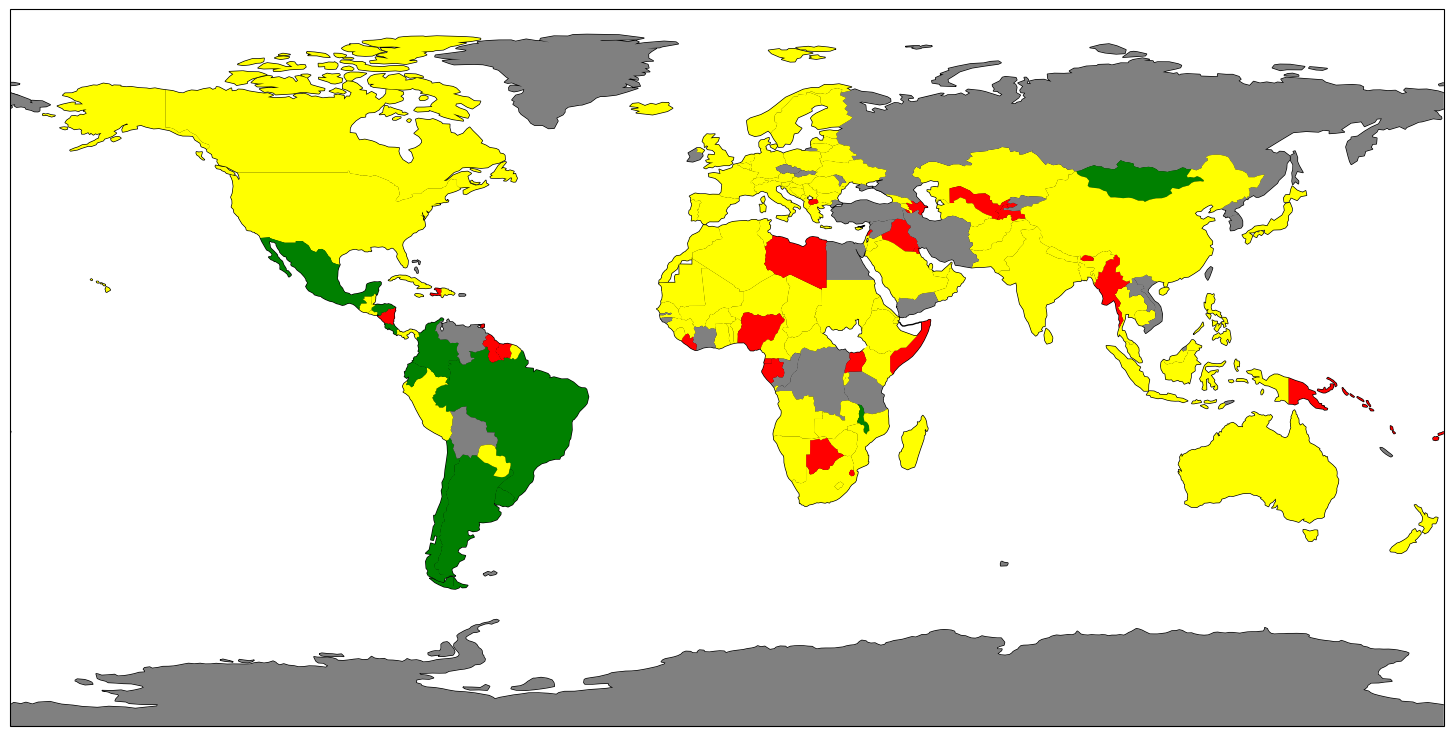

In [230]:
# Visualisation of Results
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

names = shpreader.natural_earth(resolution="110m", category="cultural", name="admin_0_countries")
countries = shpreader.Reader(names).records()

def create_map(title: str, data: pd.DataFrame, value_name: str):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(cf.BORDERS)
    ax.figure.set_size_inches(18.5, 10.5)

    max = float(data.iloc[:, -1:].max())
    min = float(data.iloc[:, -1:].min())
    diff = 0 - min
    max += diff
    min += diff

    num_cutoffs = 3.0
    cutoffs = []
    colors = ["red", "yellow", "green"]

    s = max / num_cutoffs
    for i in range(1, int(num_cutoffs)):
        cutoffs.append((s * i) - diff)
    print(cutoffs)


    for country in countries:
        try:
            name = pycountry.countries.get(alpha_3 = country.attributes['ADM0_A3']).name
        except AttributeError:
            continue
        index = data.index[data["country"] == name].to_list()
        if(len(index) > 0):
            value = float(data.at[index[0], value_name])
            color = "red"
            if math.isnan(value):
                color = "grey"
            else:
                for i in range(0, int(num_cutoffs) -1):
                    if value > cutoffs[i]:
                        color = colors[i +1]
                    else:
                        break
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor=color)
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor="grey")

    plt.savefig(title)

    plt.show()

create_map("Overall Scores", sub_indicators[["country", "final score"]], "final score")

